# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:41<00:00, 2103.26it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# Obtaining the Required DataFrame:

In [24]:
type(preprocessed_reviews)

list

Basically after all the text preprocessing we have obtained a list, whereas the dataframe that we had was named 
'final'. Initially, I had taken a total of 200k points to work upon which got reduced to approx. 160k datapoints 
after all the preprocessing and text deduplication. 

In [25]:
print(final.shape)

(87773, 10)


In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


Now I have a total of approx. 160K rows out of which I will take a total of 100K rows to apply Brute Force KNN. Here
I have the Timestamp when the review was posted, which makes it possible to apply Time Based Split of the data. 

Now to carry out the Time Based Split for the Unix Timestamp effectively, first I will sort the data based on the 
"Time" column.

In [28]:
final_TBS =final.sort_values('Time')

In [29]:
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",nothing product bother link top page buy used ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff sugar free not rot gums tastes good...


Now, the values have been sorted on the basis of Time. By default the values are sorted in ascending order.

# Obtaining Train, CV and Test Data:

First I will remember all the useless columns from my DataFrame. The only Columns over here that we are concerned
about in this case is the 'Score' and the 'Preprocessed_Reviews'. Remaining columns are of no use to us.

In [30]:
df = final_TBS[['Score','Preprocessed_Reviews']]

In [31]:
df.head()

,Score,Preprocessed_Reviews
70688,1,bought apartment infested fruit flies hours tr...
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...
28086,1,nothing product bother link top page buy used ...
28087,1,love stuff sugar free not rot gums tastes good...


In [32]:
cleandf = df[:60000]

In [33]:
Tr_df = cleandf[:42000] 
CV_df = cleandf[42000:48000]
Te_df = cleandf[48000:60000]

In [34]:
Tr_df.shape

(42000, 2)

In [35]:
CV_df.shape

(6000, 2)

In [36]:
Te_df.shape

(12000, 2)

Here I have split the entire dataframe with 60K rows into 3 parts : Train, CV as well as Test dataset into (70:10:20) ratio. I have not carried out the splitting based on "train_test_split" because I am carrying out TBS where only the most recent data is used for Testing.  

Also the shapes of the 3 dataframes have been validated. Now we are good to proceed further.

In [37]:
X_Train = Tr_df['Preprocessed_Reviews']
Y_Train = Tr_df['Score']

X_CV = CV_df['Preprocessed_Reviews']
Y_CV = CV_df['Score']

X_Test = Te_df['Preprocessed_Reviews']
Y_Test = Te_df['Score']

Therefore, everything so far is as expected where I have 42K datapoints for the Training data, 6K datapoints for the
CV Data and 12K datapoints for the Test Dataset. 

In [38]:
Y_Train.value_counts()

1    35805
0     6195
Name: Score, dtype: int64

In [39]:
Y_CV.value_counts()

1    4974
0    1026
Name: Score, dtype: int64

In [40]:
Y_Test.value_counts()

1    9831
0    2169
Name: Score, dtype: int64

Thus, this is basically an imbalanced dataset where it is skewed in the favour of class 1. We need not make each of
these datasets to be perfectly balanced in a 50-50 ratio, but still it needs to be approximately in atleast a 60-40
ratio.

However for the time being I will proceed like this to see the performance and in case the model doesn't work as 
expected on the Test Dataset I will try and make the dataset to be balanced.

# [5.1] Applying KNN Brute Force

# [5.1.1] Applying KNN Brute Force on BOW

# SET 1: Review text, preprocessed one converted into vectors using (BOW)

In [41]:
count_vect = CountVectorizer()
count_vect.fit(X_Train) #fit is being carried out only on the Train Data

#fit function over here basically internally stores the parameters that will be used for Transforming the data from
#text to a numerical vector.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [42]:
X_Train_BOW = count_vect.transform(X_Train)
X_CV_BOW = count_vect.transform(X_CV)
X_Test_BOW = count_vect.transform(X_Test)

#Now all the text has been transformed to the Numerical vector that we needed. 

In [43]:
print("Shapes before the Vectorization was carried out:")
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape,Y_CV.shape)
print(X_Test.shape,Y_Test.shape)

print("*"*100)

#*************************************************************************************************
print("Shapes after the Vectorization was carried out:")
print(X_Train_BOW.shape, Y_Train.shape)
print(X_CV_BOW.shape,Y_CV.shape)
print(X_Test_BOW.shape,Y_Test.shape)

Shapes before the Vectorization was carried out:
(42000,) (42000,)
(6000,) (6000,)
(12000,) (12000,)
****************************************************************************************************
Shapes after the Vectorization was carried out:
(42000, 38363) (42000,)
(6000, 38363) (6000,)
(12000, 38363) (12000,)


Initially, all the Train, CV and Test Datasets for X had a single column depicting the preprocessed
review text. Now what is done is done in each of the different stages is as follows:
    
* count_vect.fit(X_Train):- Internally, the vocabulary is learnt only of the Training data ie. all the different       words that are present in the Training data. Basically, the training data has 38363 unique words.
* count_vect.transform(X_Train) :- This basically is applying the learnt vocabulary in the BOW format and converting
  the text into a numeric vector that stores the frequency of occurences of the words.
* count_vect.transform(X_CV) & count_vect.transform(X_Test)  :- Only the words that are present in the Training data   Vocabulary are taken into consideration and any of the new words encountered are not considered. This will       basically ensure that the dimensionality of the CV and the Test datasets remain the same.


# Hyperparameter Tuning on the Brute Force BOW Representation :- 

Before K-NN is applied on the Test dataset it is important to determine the best possible value for K. This can be
calculated on the CV data by either simple Cross-Validation or K-fold Cross Validation. However I will be employing
simple Cross Validation to determine the value of K that results in the lowest error (or highest accuracy) on the CV
dataset.

In [44]:
k_param = []
#initializing an empty list

for k in range(1,60,2):
    k_param.append(k)      

In [45]:
print(k_param)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]


I have defined a list with the different possible values of the hyperparameter K ranging from 1 to 59. I have only
taken odd numbers in this range because it is always better to take odd values for K because we do not want any ties
in the case of majority vote.

In [46]:
#Importing the required Packages

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt  

from tqdm import tqdm
#tqdm has been used to print the status bar 

In [47]:
Train_AUC = []
CV_AUC = []
# 2 Empty Lists have been defined each for Train AUC Values and CV AUC Values.

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors=k,algorithm ='brute',n_jobs=-1)
    # I have taken n_jobs=-1 so as to parallelise the entire execution. A specification of -1 in this scenario
    # means to use all the processors that are available.
    
    neigh.fit(X_Train_BOW,Y_Train) 
    
    Y_Train_pred1 = neigh.predict_proba(X_Train_BOW)[:,1]
    Y_CV_pred1 = neigh.predict_proba(X_CV_BOW)[:,1]
    
    Train_AUC.append(roc_auc_score(Y_Train,Y_Train_pred1))
    CV_AUC.append(roc_auc_score(Y_CV,Y_CV_pred1))

100%|██████████| 30/30 [1:35:37<00:00, 191.40s/it]


The first column in X_Train_BOW as well as for X_CV_BOW is the index value which is of no use to us. Hence I will only consider the second column.

Also, the task in hand is to plot the AUC curve. Documentation of the AUC curve is as follows:
    
    roc_auc_score(y_true,y_score) :- 
    
    y_true is the actual class label. On the other hand, y_score is NOT the predicted class label. Instead y_score
    is the probability estimate of the positive class. ie. probability that y=1.
    
We also need to keep all these lines of code inside the for loop because we need to compute the ROC Score for all
the different possible values of k that we have taken.

Plotting the Plot to find the Best Value of K:-

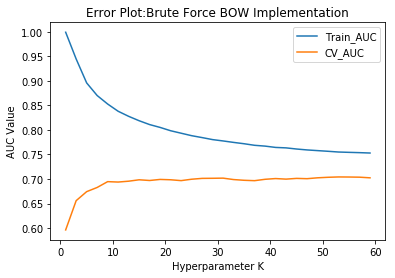

In [48]:
#Plotting the Training AUC for different values of K:-
plt.plot(k_param,Train_AUC,label='Train_AUC')

#Plotting the Cross Validation AUC for different values of K:-
plt.plot(k_param,CV_AUC,label='CV_AUC')

plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Value')
plt.title('Error Plot:Brute Force BOW Implementation')

plt.show()

From the curves plotted above we choose the Best value of K on the basis of AUC as a metric such that :
* The AUC value on the CV Dataset is the maximum. 
* The gap between the Train and CV AUC Curves is low. 

Therefore based on these 2 conditions, with the help of the curves above, I can choose the best value of K to be 
equal to :

In [49]:
best_k = 59

#Since the AUC value in this scenario is approx. 0.70 throughout but as the value of K is equal to 59, the gap is
#minimum.

# Testing with the Test Data for Brute Force BOW:- 

Firstly I will train using the Training data with this value of K=59, that was obtained after the Hyperparameter 
tuning using the CV data. 

In [50]:
neigh1 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh1.fit(X_Train_BOW,Y_Train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=59, p=2,
           weights='uniform')

In [51]:
Y_Train.shape

(42000,)

In [52]:
print(X_Train_BOW.shape)

(42000, 38363)


The thing to be noted in this scenario is the fact that the syntax for roc_curve is as follows :
    
                             roc_curve(y_true,y_score)
        
        * y_true are the true binary labels.
        * On the other hand, y_score is the probability score. 
        
roc_curve basically returns 3 arrays as follows :
    
    * FPR :- FPR of the predictions. 
    * TPR :- TPR of the predictions. 
    * thresholds :- Threshold values arranged in their decreasing order.
    
Also it is to be made sure that the dimensionality of both X_Train_BOW as well as Y_Train are the same. Otherwise
we get a "ValueError" that says "bad input shape". Hence only the 1st column is considered.
    

Similarly for the Test Dataset:-

In [53]:
Y_Test.shape

(12000,)

In [54]:
X_Test_BOW.shape

(12000, 38363)

In [55]:
from sklearn.metrics import roc_curve,auc

train_fpr, train_tpr, thresholds = roc_curve(Y_Train,neigh1.predict_proba(X_Train_BOW)[:,1])
test_fpr,test_tpr, thresholds = roc_curve(Y_Test,neigh1.predict_proba(X_Test_BOW)[:,1])

Plotting the graph is as follows:-

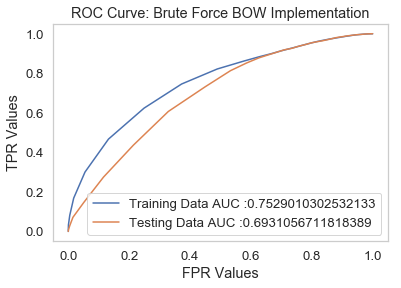

In [114]:
import matplotlib.pyplot as plt

plt.plot(train_fpr,train_tpr, label ="Training Data AUC :" + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Testing Data AUC :" + str(auc(test_fpr,test_tpr)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('ROC Curve: Brute Force BOW Implementation')

plt.grid(False)
plt.show()

Basically here, this is a 1X1 square and the Training Data AUC is equal to 0.75, whereas the AUC on Test data is 
equal to 0.69. It is to be noted that Area under the diagonal is equal to 0.5, and any value greater than 0.5 is 
good for a sensible model. 

However at the same time it is to be noted that AUC is a metric that is also significantly impacted by imbalanced data. 

In [57]:
#To plot the confusion matrix
Y_Test_pred1 = neigh1.predict_proba(X_Test_BOW)[:,1]

<b> <font color="black"> Function to Obtain the Best Threshold & Predictions:- </font> </b>

In [83]:
def matrixpredict(data,thresholds,tpr,fpr):   
    matrixpredict.best_tradeoff = tpr*(1-fpr)
    matrixpredict.ideal_threshold = thresholds[matrixpredict.best_tradeoff.argmax()]
 
    predictions=[]
    
    for i in data:
        if i>= matrixpredict.ideal_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<b> <font color="black"> Function to Plot the Training Confusion Matrix HeatMap:- </font> </b>

In [84]:
import seaborn as sns

def plottrainmatrix (train_matrix):
    sns.set_style("whitegrid")
    
    labels = [0,1]
    
    print("-"*20, "Training Confusion Matrix", "-"*20)
    print(" ")
    print("The Training Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(train_matrix,
                annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()   

<b> <font color="black"> Function to Plot the Test Confusion Matrix HeatMap:- </font> </b>

In [85]:
import seaborn as sns

def plottestmatrix (test_matrix):
    labels = [0,1]
    
    print("-"*20, "Test Data Confusion Matrix", "-"*20)
    print(" ")
    print("The Test Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(test_matrix,annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, 
                yticklabels=labels,annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()     

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.46844662917770785
Threshold for Maximum Value of tpr*(1-fpr) : 0.898


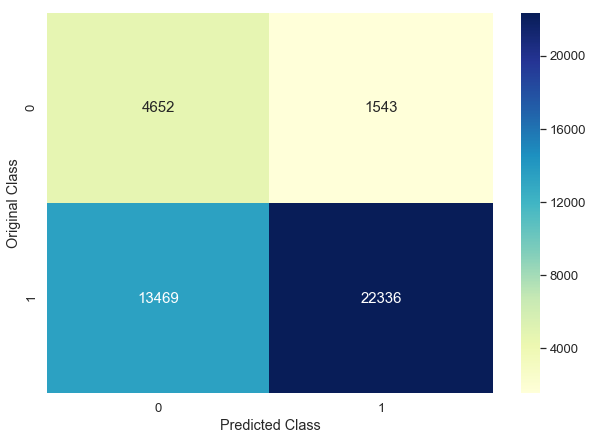

In [71]:
A = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred1,thresholds,train_tpr,train_fpr))
plottrainmatrix(A)

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.4073684362076868
Threshold for Maximum Value of tpr*(1-fpr) : 0.898


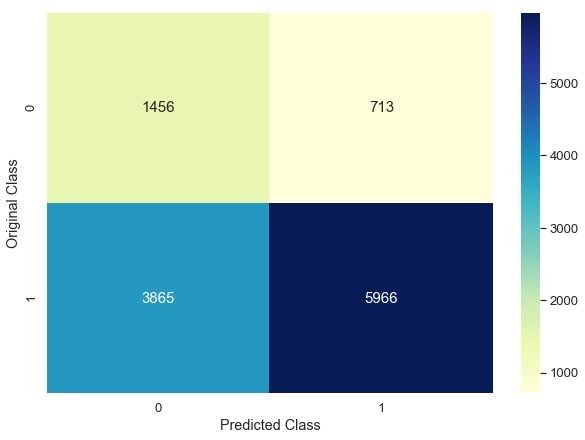

In [73]:
B = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred1,thresholds,test_tpr,test_fpr))
plottestmatrix(B)

* In the case of obtaining the Confusion Matrix, we no longer require the value of probability of prediction for a 
  positive class label. Rather we require the actual prediction itself of the class label. 

Therefore in this scenario, TPR = 5966/(5966+713) => 0.89 ie 89%. We wanted this value to be as high as possible for
the Test Data. 
FPR = 3865/(1456+3865) => 0.72 ie 72%. We wanted this value to be as small as possible. 

Overall Accuracy = (5966+1456)/12000 => 61.85%.

# [5.1.2] Applying KNN Brute Force on TFIDF

# SET 2 : Review text, preprocessed one converted into vectors using (TFIDF)

In [74]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#While the vocabulary is being built on the Training data using TFIDF, all the words with a frequency lower than the
#value =10 are ignored. Also, both unigram and bi-grams are considered. Also, only the top 12000 features over here
#are taken into consideration.

tf_idf_vect.fit(X_Train)
#Again, 'fitting' has been carried out only on the Training data. 

#fit function over here basically internally stores the parameters that will be used for Transforming the data from
#text to a numerical vector :- Using TFIDF in this case. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [75]:
X_Train_TFIDF = tf_idf_vect.transform(X_Train)
X_CV_TFIDF = tf_idf_vect.transform(X_CV)
X_Test_TFIDF = tf_idf_vect.transform(X_Test)

#Again, all the text has been transformed to the Numerical vector that we needed.

In [76]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_Train.shape,Y_Train.shape)
print(X_CV.shape,Y_CV.shape)
print(X_Test.shape,Y_CV.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_Train_TFIDF.shape,Y_Train.shape)
print(X_CV_TFIDF.shape,Y_CV.shape)
print(X_Test_TFIDF.shape,Y_Test.shape)

Shapes before the TFIDF Vectorization was carried out:
(42000,) (42000,)
(6000,) (6000,)
(12000,) (6000,)
Shapes after the TFIDF Vectorization was carried out:
(42000, 24890) (42000,)
(6000, 24890) (6000,)
(12000, 24890) (12000,)


Initially, all the Train, CV and Test Datasets for X had a single column depicting the preprocessed
review text. Now what is done is done in each of the different stages is as follows:
    
* tf_idf_vect.fit(X_Train):- Internally, the vocabulary is learnt only of the Training data ie. all the different       words that are present in the Training data. Basically, the training data has 24890 words when both uni-grams
  as well as bi-gram representations are taken into consideration.
* tf_idf_vect.transform(X_Train) :- This basically is applying the learnt vocabulary in the TFIDF format and converting the text into a numeric vector that stores the frequency of occurences of the words.
* tf_idf_vect.transform(X_CV) & tf_idf_vect.transform(X_Test)  :- Only the words that are present in the Training data Vocabulary are taken into consideration and any of the new words encountered are not considered. This will       basically ensure that the dimensionality of the CV and the Test datasets remain the same.

# Hyperparameter Tuning on the Brute Force TFIDF Representation:-

Again, I will try and find the best value of K for the TFIDF representation based on the AUC values for the
Train & CV Datasets.

In [77]:
print(k_param)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]


In [78]:
Train_TFIDF_AUC = []
CV_TFIDF_AUC = []

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors =k,n_jobs=-1,algorithm='brute')
    
    neigh.fit(X_Train_TFIDF,Y_Train)
    
    Y_Train_pred2 = neigh.predict_proba(X_Train_TFIDF)[:,1]
    Y_CV_pred2 = neigh.predict_proba(X_CV_TFIDF)[:,1]
    
    Train_TFIDF_AUC.append(roc_auc_score(Y_Train,Y_Train_pred2))
    CV_TFIDF_AUC.append(roc_auc_score(Y_CV,Y_CV_pred2))    

100%|██████████| 30/30 [1:57:17<00:00, 211.62s/it]


Plotting of the AUC Score values for the different values of K, the plot will look like as follows :  

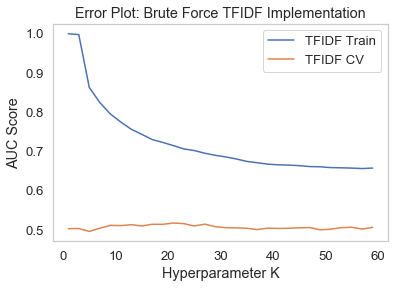

In [113]:
#Plotting AUC Scores for different values of K
import matplotlib.pyplot as plt

plt.plot(k_param,Train_TFIDF_AUC,label= 'TFIDF Train')
plt.plot(k_param,CV_TFIDF_AUC,label='TFIDF CV')
plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Score')
plt.title('Error Plot: Brute Force TFIDF Implementation')

plt.grid(False)
plt.show()       

From the curves plotted above we choose the Best value of K on the basis of AUC as a metric such that :
* The AUC value on the CV Dataset is the maximum. 
* The gap between the Train and CV AUC Curves is low. 

Again based on these 2 conditions, with the help of the curves above, I can choose the best value of K to be 
equal to :

In [88]:
best_k=59

# Testing on the Test Dataset for TFIDF :- 

Best value of k =59. Therefore, first I will train the model on the Training Data and then test on the Test dataset. 

In [89]:
neigh2 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh2.fit(X_Train_TFIDF,Y_Train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=59, p=2,
           weights='uniform')

In [90]:
X_Train_TFIDF.shape

(42000, 24890)

In [91]:
Y_Train.shape

(42000,)

In [92]:
X_Test_TFIDF.shape

(12000, 24890)

In [93]:
Y_Test.shape

(12000,)

In [94]:
from sklearn.metrics import roc_auc_score

train_fpr2,train_tpr2,thresholds = roc_curve(Y_Train,neigh2.predict_proba(X_Train_TFIDF)[:,1])
test_fpr2,test_tpr2,thresholds = roc_curve(Y_Test,neigh2.predict_proba(X_Test_TFIDF)[:,1])

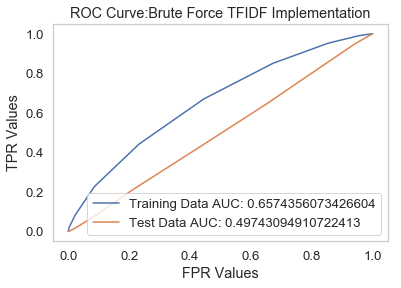

In [112]:
#Plotting the ROC Plot, it will look like as follows:

import matplotlib.pyplot as plt

plt.plot(train_fpr2,train_tpr2,label = "Training Data AUC: " + str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2,label = "Test Data AUC: " + str(auc(test_fpr2,test_tpr2)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('ROC Curve:Brute Force TFIDF Implementation')

plt.grid(False)
plt.show()

In this particular case, Test Data AUC = 0.497 ~ 0.50 ie. the Test AUC Score is roughly equivalent to the AUC Score 
of a random model.

<b> NOTE :- In this particular case I tried the following approaches in order to increase the value of Test AUC Value: </b> 
  * Using only the top 2000 Features:- In such a scenario I was able to marginally improve the value of Test             AUC to 0.52.
  * Using weights ='distance' as a parameter for the KNN Model to try and curb the imbalanced dataset. In such
    a scenario the Training AUC became very high ie. 0.99 whereas the Testing AUC remained the same : equal to
    0.49 which meant that I was overfitting on the dataset.

<b> <font color="black"> Plotting the Confusion Matrices for the TFIDF Train Data & Test Data for the Ideal Value
of the Threshold:- </font> </b>

In [96]:
#To plot the confusion matrix
Y_Test_pred2 = neigh2.predict_proba(X_Test_TFIDF)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.37172786545902214
Threshold for Maximum Value of tpr*(1-fpr) : 0.898


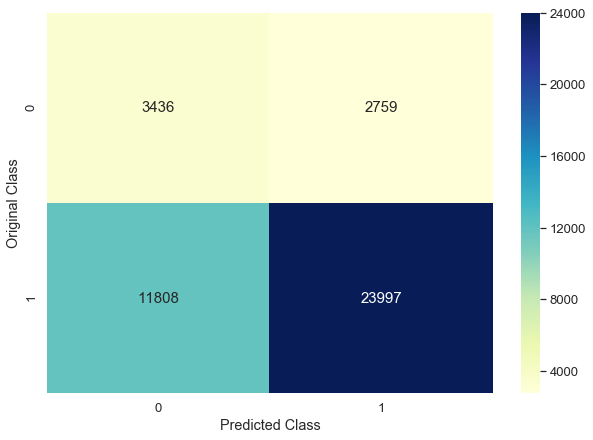

In [98]:
C = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred2,thresholds,train_tpr2,train_fpr2))
plottrainmatrix(C)

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.2414936915194589
Threshold for Maximum Value of tpr*(1-fpr) : 0.915


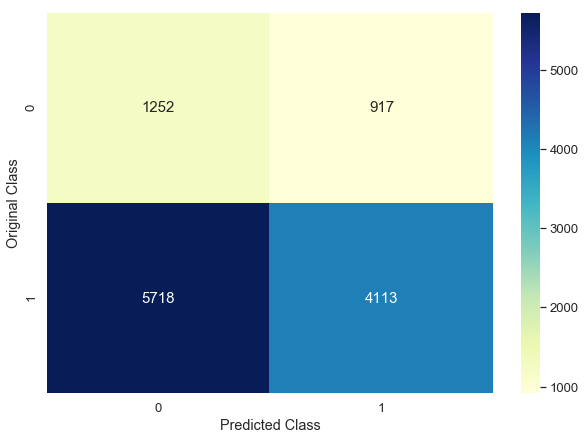

In [99]:
D = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred2,thresholds,test_tpr2,test_fpr2))
plottestmatrix(D)

Therefore in this scenario Overall Accuracy on the Test Data :
    (4113+1252)/12000 => 44.70%

# [5.1.3] Applying KNN Brute Force on Avg W2V

# SET 3 : Review text, preprocessed one converted into vectors using (AVG W2V)

In [100]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [101]:
list_of_sentence_Train =[]

for sentence in X_Train:
    list_of_sentence_Train.append(sentence.split())

# Training W2V Model :-

In [102]:
w2v_model=Word2Vec(list_of_sentence_Train,min_count=5,size=50, workers=4)

* list_of_sentence_Train :- All the sentences from the training dataset are concatenated into a single 
  list and the words in the sentences are separated on the basis of each whitespace. 
* min_count :- Ignores all the words with total frequency of the word lower than the value specified in this case. 
* size :- Specifies the Dimensionality of the Word vectors. 
* workers :- Uses the specified number of worker threads to train the Word2Vec model. (Basically, for the multi-core
  machines, the training will be faster.)

In [103]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occur a minimum 5 times :",len(w2v_words))
print("Some of the sample words are as follows: ", w2v_words[0:50])

Number of words that occur a minimum 5 times : 12355
Some of the sample words are as follows:  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


# Converting Reviews into Numerical Vectors using W2V vectors :-

# Converting the Train Data Text :-

In [104]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Train): # for each review/sentence for Training Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 42000/42000 [01:42<00:00, 410.22it/s]

(42000, 50)
[ 3.57781308e-02 -5.03235909e-01 -3.64517056e-01 -1.25938655e-01
  2.09221604e-01  6.83376970e-01 -3.52995431e-01  3.32817781e-01
  3.67676901e-01 -2.78494973e-01 -8.85317314e-01  2.44230509e-01
  4.57375844e-01  7.17406886e-01  1.72396034e-01  1.81211725e-01
 -1.59843497e-02  2.83601598e-03 -1.79738521e-01  6.28529388e-02
 -2.59153491e-02 -2.33970462e-01 -3.43425096e-01 -3.36957213e-02
  2.60266946e-01  6.23388882e-01 -2.62855999e-02  1.82997143e-01
  6.11085670e-01 -7.40089755e-02 -2.19283354e-02  1.26739254e-01
  1.69491045e-01 -2.94572566e-02 -9.59874700e-02 -1.58585255e-01
  4.84539766e-01 -1.12910408e-01 -1.64568329e-02 -2.36907289e-01
  3.56008180e-01  7.88719453e-02  1.48955157e-01  1.81546368e-01
  3.70693429e-02 -2.67146160e-01 -1.26031372e-01  5.01177313e-04
  3.56509541e-01 -3.43208629e-02]


# Converting the CV Data Text :- 

In [105]:
list_of_sentence_CV=[]

for sentence in X_CV:
    list_of_sentence_CV.append(sentence.split())

In [106]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the CV Dataset.
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 6000/6000 [00:16<00:00, 363.80it/s]


(6000, 50)
[-4.19099784e-01 -4.71884267e-01 -2.43486355e-01 -1.71034752e-01
  2.67392180e-01  6.66928966e-01 -1.13697479e-01 -1.93602538e-01
 -3.02643624e-01  7.04628081e-01 -9.03276294e-01 -1.39148438e+00
  6.44862117e-01 -2.05730065e-01 -6.96231055e-01  2.79460914e-01
 -2.34656752e-01 -1.29218011e+00  2.43668424e-01  2.83758703e-01
 -1.98566924e-01  1.93605960e-01 -9.32182879e-02 -9.37580742e-02
 -2.84052036e-01  6.45202406e-02  7.44506816e-03 -4.07090373e-01
  6.65264439e-01  1.16960672e-01 -8.18710472e-01  4.32051641e-01
 -3.13274557e-02  3.60205697e-01 -1.03169944e+00 -7.94614851e-04
  5.47792438e-01 -3.58724461e-01 -4.26967950e-01 -2.05643192e-01
  1.72496385e-01 -1.59320216e-01  1.37290473e+00  6.29390981e-01
  2.84352422e-01 -2.28204285e-01 -5.19059749e-01 -6.16607696e-01
 -4.55350249e-01  7.99397871e-01]


# Converting the Test Dataset :- 

In [107]:
list_of_sentence_Test=[]

for sentence in X_Test:
    list_of_sentence_Test.append(sentence.split())

In [108]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 12000/12000 [00:31<00:00, 382.10it/s]

(12000, 50)
[-0.72903066 -0.36167051  0.19627815  0.25124973  0.59142036  0.44034968
 -0.45460785  0.66629154  0.01092037  0.64816574 -0.57218671  0.27474842
  0.291848    0.56066525  0.00595089 -0.09324778  0.18564219  0.18972215
  0.5159613  -0.34921667  0.69786716 -0.6000267  -0.04352826 -0.51405098
  0.33708629  0.30169539  0.38299817 -0.27099838  0.88270527 -0.78663577
 -0.25579371 -0.1301484  -0.50152111 -0.08355137 -0.54204937  0.40518817
 -0.42599279 -0.73905504 -0.36720081 -0.18848703  0.11361511 -0.26740374
  0.07215057  0.92562593  0.50184381  0.01849335  0.66520146  0.06799433
  0.26316958  0.31040678]


# Hyperparameter Tuning on the Brute Force Avg W2V Representation :-

In [109]:
print(k_param)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]


In [110]:
Train_AW2V_AUC=[]
CV_AW2V_AUC=[]

for k in tqdm(k_param):
    neigh3 = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    neigh3.fit(sent_vectors_train,Y_Train)
    
    Y_Train_pred3 = neigh3.predict_proba(sent_vectors_train)[:,1]
    Y_CV_pred3 = neigh3.predict_proba(sent_vectors_cv)[:,1]
    
    Train_AW2V_AUC.append(roc_auc_score(Y_Train,Y_Train_pred3))
    CV_AW2V_AUC.append(roc_auc_score(Y_CV,Y_CV_pred3))

100%|██████████| 30/30 [1:33:48<00:00, 167.82s/it]


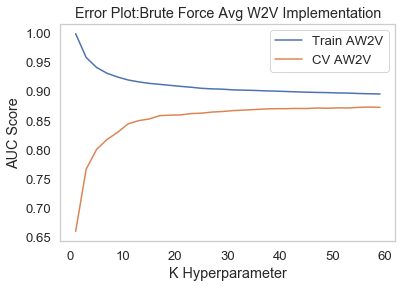

In [115]:
#Plotting the AUC Values for the different values of K:-

import matplotlib.pyplot as plt

plt.plot(k_param,Train_AW2V_AUC, label='Train AW2V')
plt.plot(k_param,CV_AW2V_AUC, label = 'CV AW2V')
plt.legend()

plt.xlabel('K Hyperparameter')
plt.ylabel('AUC Score')
plt.title('Error Plot:Brute Force Avg W2V Implementation')


plt.grid(False)
plt.show()

Again, the best value for K will be for k=59 since the CV value is maximum for k=59 and alongwith that the gap 
between the Train and Test curves is the minimum in this scenario. 

In [116]:
best_k = 59

# Testing on the Test Dataset for AW2V Representation:-

In [117]:
neigh3 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh3.fit(sent_vectors_train,Y_Train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=59, p=2,
           weights='uniform')

In [118]:
sent_vectors_train.shape

(42000, 50)

In [119]:
Y_Train.shape

(42000,)

In [120]:
sent_vectors_test.shape

(12000, 50)

In [121]:
Y_Test.shape

(12000,)

In [122]:
from sklearn.metrics import roc_auc_score

train_fpr3,train_tpr3,thresholds = roc_curve(Y_Train,neigh3.predict_proba(sent_vectors_train)[:,1])
test_fpr3,test_tpr3,thresholds = roc_curve(Y_Test,neigh3.predict_proba(sent_vectors_test)[:,1])

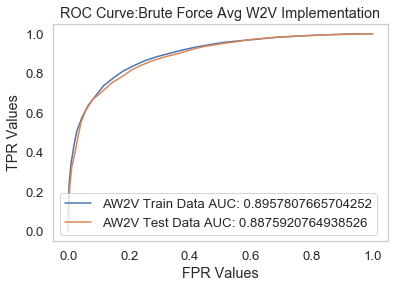

In [123]:
#Plotting the ROC plot, it will look like as follows:-

import matplotlib.pyplot as plt

plt.plot(train_fpr3,train_tpr3,label = "AW2V Train Data AUC: " + str(auc(train_fpr3,train_tpr3)))
plt.plot(test_fpr3,test_tpr3,label = "AW2V Test Data AUC: " + str(auc(test_fpr3,test_tpr3)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve:Brute Force Avg W2V Implementation')

plt.grid(False)
plt.show()

In this particular scenario, Test Data AUC = 0.88 ie. 88%, which is excellent, since the AUC score for a random
model =  0.5. So this model of ours is much better than a random model.

<b> <font color="black"> Plotting the Confusion Matrices for the Avg W2V Train Data & Test Data for the Ideal Value
of the Threshold:- </font> </b>

In [124]:
#To plot the confusion matrix
Y_Test_pred3 = neigh3.predict_proba(sent_vectors_test)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6651115793004413
Threshold for Maximum Value of tpr*(1-fpr) : 0.831


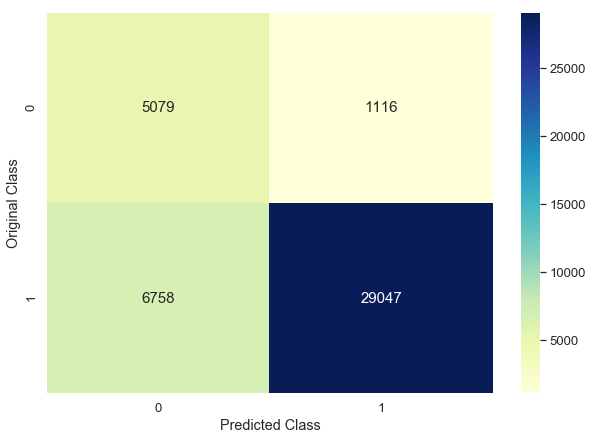

In [125]:
E = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred3,thresholds,train_tpr3,train_fpr3))
plottrainmatrix(E)

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6468048610733006
Threshold for Maximum Value of tpr*(1-fpr) : 0.814


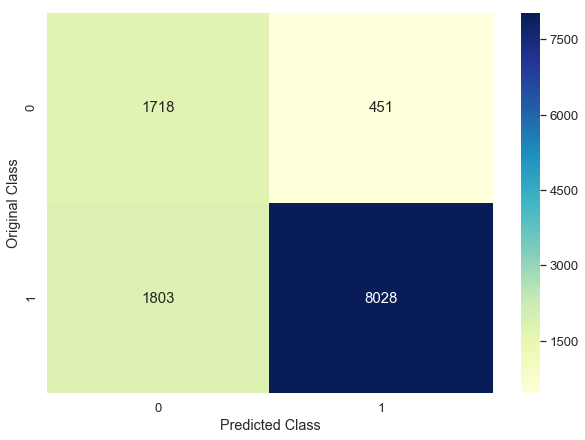

In [126]:
F = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred3,thresholds,test_tpr3,test_fpr3))
plottestmatrix(F)

Overall Accuracy on Test Data => (8028+1718)/12000 => 81.21 %

# [5.1.4] Applying KNN Brute Force on TFIDF W2V

# SET 4 : Review text, preprocessed one converted into vectors using (TFIDF W2V)

In [127]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_Train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [128]:
tf_idf_matrix.shape

(42000, 38363)

So basically tf_idf_matrix has learnt the vocabulary from X_Train and now we will apply the same on the Cross 
Validation as well as the Test Datasets.

# Converting the Train Data Text :-

In [129]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review from Training Data is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Train): # for each review/sentence in Training Data
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 42000/42000 [20:01<00:00, 34.95it/s]  


In [130]:
tfidf_sent_vectors_train[1]

array([ 0.06277747, -0.40467666, -0.03354876, -0.04975851,  0.18219422,
        0.48792574, -0.14486867,  0.11471225,  0.08697792, -0.07927863,
       -0.73751171, -0.21876341,  0.35185851,  0.34984202,  0.04489105,
        0.08855308, -0.14265005, -0.08930969,  0.27598711,  0.14127075,
       -0.47025253, -0.17900176,  0.16689619, -0.02674882,  0.14204128,
        0.62933901, -0.12902042, -0.02440702,  0.43945932,  0.0794379 ,
       -0.14404407, -0.13911979,  0.16627629,  0.39320816, -0.39164954,
        0.07084624,  0.36505694, -0.52982255, -0.33906502, -0.23815053,
        0.3025529 , -0.23598862,  0.17704226,  0.3083314 , -0.02757735,
       -0.47829414,  0.031841  , -0.40044743, -0.23794553, -0.02690124])

# Converting the CV Data Text :-

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review from the CV Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the Cross Validation Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [02:59<00:00, 30.35it/s]


# Converting the Test Data Text :-

In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review from the Test Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 12000/12000 [05:43<00:00, 34.98it/s]


# Hyperparameter Tuning on the TFIDF W2V Representation :-

In [133]:
print(k_param)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]


In [134]:
Train_TFIDF_W2V_AUC = []
CV_TFIDF_W2V_AUC = []

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    neigh.fit(tfidf_sent_vectors_train,Y_Train)
    
    Y_Train_pred4 = neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_CV_pred4 = neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    Train_TFIDF_W2V_AUC.append(roc_auc_score(Y_Train,Y_Train_pred4))
    CV_TFIDF_W2V_AUC.append(roc_auc_score(Y_CV,Y_CV_pred4))    

100%|██████████| 30/30 [2:30:49<00:00, 256.64s/it]  


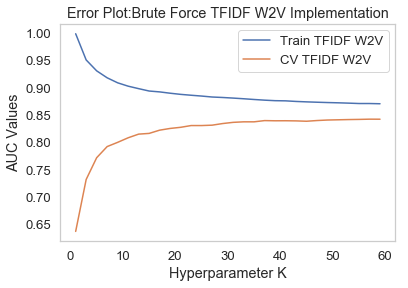

In [135]:
#Plotting the AUC Plots for Train and CV Datasets:

import matplotlib.pyplot as plt

plt.plot(k_param,Train_TFIDF_W2V_AUC, label = 'Train TFIDF W2V')
plt.plot(k_param,CV_TFIDF_W2V_AUC, label='CV TFIDF W2V')
plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Values')
plt.title('Error Plot:Brute Force TFIDF W2V Implementation')

plt.grid(False)
plt.show()

Again, according to our criteria in choosing the best value of K, we look for the value of K with the highest value 
of CV AUC Value and at the same time the smallest difference between the Train and CV AUC curves. Based on this,
best value of K=59.

In [136]:
best_k=59

# Testing on the Test Dataset for the TFIDF W2V Representation:-

In [137]:
neigh4 = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh4.fit(tfidf_sent_vectors_train,Y_Train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=59, p=2,
           weights='uniform')

In [138]:
from sklearn.metrics import roc_auc_score

train_fpr4,train_tpr4,thresholds = roc_curve(Y_Train,neigh4.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr4,test_tpr4,thresholds = roc_curve(Y_Test,neigh4.predict_proba(tfidf_sent_vectors_test)[:,1])

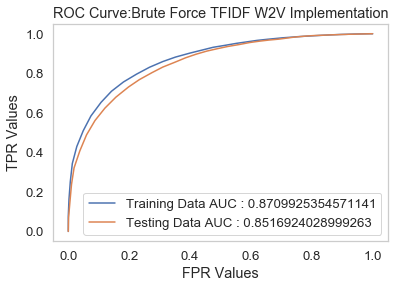

In [139]:
#Plotting the ROC Curve on the Testing Data:-
import matplotlib.pyplot as plt

plt.plot(train_fpr4,train_tpr4, label = 'Training Data AUC : ' + str(auc(train_fpr4,train_tpr4)))
plt.plot(test_fpr4,test_tpr4, label = 'Testing Data AUC : ' + str(auc(test_fpr4,test_tpr4)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve:Brute Force TFIDF W2V Implementation')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the TFIDF W2V Train Data & Test Data for the Ideal Value
of the Threshold:- </font> </b>

In [141]:
#To plot the confusion matrix
Y_Test_pred4 = neigh4.predict_proba(tfidf_sent_vectors_test)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6189884022267057
Threshold for Maximum Value of tpr*(1-fpr) : 0.847


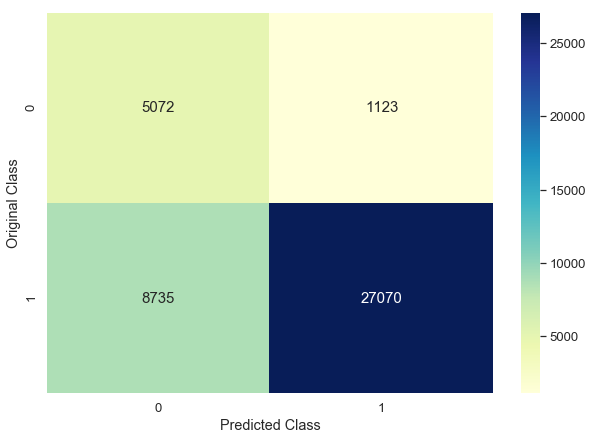

In [142]:
G = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred4,thresholds,train_tpr4,train_fpr4))
plottrainmatrix(G)

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5885852183599465
Threshold for Maximum Value of tpr*(1-fpr) : 0.831


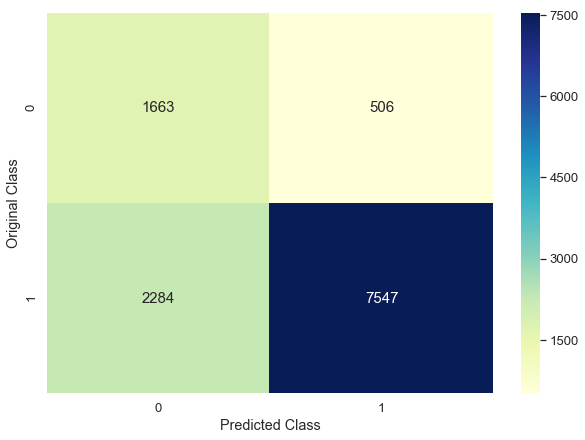

In [143]:
H = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred4,thresholds,test_tpr4,test_fpr4))
plottestmatrix(H)

From the Testing Data Confusion Matrix, Accuracy = (7547+1663)/12000 => 0.7675. ie there is an 76.75% Accuracy on the Test
Data. 

# [5.2] Applying KNN KD-Tree

# [5.2.1] Applying KNN KD-Tree on BOW

# SET 5 : Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.

In [144]:
count_vect_KD = CountVectorizer(min_df=10,max_features=500)
count_vect_KD.fit(X_Train) #fit is being carried out only on the Train Data

#fit function over here basically internally stores the parameters that will be used for Transforming the data from
#text to a numerical vector.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [145]:
type(count_vect_KD)

sklearn.feature_extraction.text.CountVectorizer

In [146]:
X_Train_KDBOW = count_vect_KD.transform(X_Train)
X_CV_KDBOW = count_vect_KD.transform(X_CV)
X_Test_KDBOW = count_vect_KD.transform(X_Test)

#Now all the text has been transformed to the Numerical vector that we needed. 

In [147]:
print("Shapes before the Vectorization was carried out:")
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape,Y_CV.shape)
print(X_Test.shape,Y_Test.shape)

print("*"*100)

#*************************************************************************************************
print("Shapes after the Vectorization was carried out:")
print(X_Train_KDBOW.shape, Y_Train.shape)
print(X_CV_KDBOW.shape,Y_CV.shape)
print(X_Test_KDBOW.shape,Y_Test.shape)

Shapes before the Vectorization was carried out:
(42000,) (42000,)
(6000,) (6000,)
(12000,) (12000,)
****************************************************************************************************
Shapes after the Vectorization was carried out:
(42000, 500) (42000,)
(6000, 500) (6000,)
(12000, 500) (12000,)


In [148]:
type(X_Train_KDBOW)
type(X_CV_KDBOW)
type(X_Test_KDBOW)

scipy.sparse.csr.csr_matrix

In this particular scenario, all of our vectorizations are sparse matrices. However, in order to implement the 
kd-tree algorithm, we need to convert all of these sparse matrices to dense matrices, which can be achieved as
follows: 

In [149]:
X_Train_KDBOW = X_Train_KDBOW.toarray()
X_CV_KDBOW = X_CV_KDBOW.toarray()
X_Test_KDBOW = X_Test_KDBOW.toarray()

In [150]:
type(X_Train_KDBOW)
type(X_CV_KDBOW)
type(X_Test_KDBOW)

numpy.ndarray

ie Basically we have converted the sparse matrices in this scenario into dense matrix representation using toarray()
function.

# Hyperparameter Tuning on the BOW Representation using KD-Tree :- 

In [156]:
Train_KDBOW_AUC = []
CV_KDBOW_AUC = []

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(X_Train_KDBOW,Y_Train)
    
    Y_Train_pred5 = neigh.predict_proba(X_Train_KDBOW)[:,1]
    Y_CV_pred5 = neigh.predict_proba(X_CV_KDBOW)[:,1]
    
    Train_KDBOW_AUC.append(roc_auc_score(Y_Train,Y_Train_pred5))
    CV_KDBOW_AUC.append(roc_auc_score(Y_CV,Y_CV_pred5))

100%|██████████| 30/30 [6:13:27<00:00, 725.88s/it]   


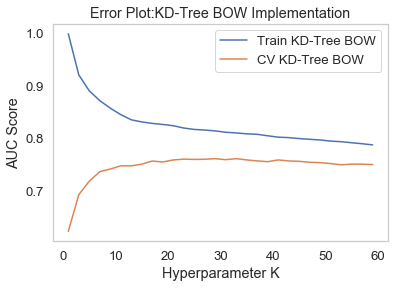

In [168]:
#Plotting the AUC Scores for the different values of the Hyperparameter K:-

import matplotlib.pyplot as plt

plt.plot(k_param,Train_KDBOW_AUC, label='Train KD-Tree BOW')
plt.plot(k_param,CV_KDBOW_AUC, label='CV KD-Tree BOW')
plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Score')
plt.title('Error Plot:KD-Tree BOW Implementation')

plt.grid(False)
plt.show()

Again, based on the CV and Train Data Curves for the AUC values and based on our criteria in choosing the best
possible value of K, we can choose K=53.

In [169]:
best_k= 53

# Testing on the Test Dataset for the BOW Representation using KD-Tree:-

In [170]:
neigh5 = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
neigh5.fit(X_Train_KDBOW,Y_Train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=53, p=2,
           weights='uniform')

In [171]:
X_Train_KDBOW.shape

(42000, 500)

In [172]:
Y_Train.shape

(42000,)

In [173]:
X_Test_KDBOW.shape

(12000, 500)

In [174]:
Y_Test.shape

(12000,)

In [175]:
from sklearn.metrics import roc_auc_score

train_fpr5,train_tpr5,thresholds = roc_curve(Y_Train,neigh5.predict_proba(X_Train_KDBOW)[:,1])
test_fpr5,test_tpr5,thresholds = roc_curve(Y_Test,neigh5.predict_proba(X_Test_KDBOW)[:,1])

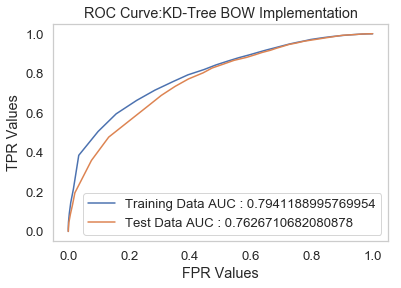

In [177]:
#Plotting the ROC Curves for the Training and Test Datasets:-

import matplotlib.pyplot as plt

plt.plot(train_fpr5,train_tpr5, label='Training Data AUC : ' + str(auc(train_fpr5,train_tpr5)))
plt.plot(test_fpr5,test_tpr5, label='Test Data AUC : ' + str(auc(test_fpr5,test_tpr5)))

plt.legend()
plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve:KD-Tree BOW Implementation')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the BOW Train Data & Test Data (KD-Tree Implementation)
for the Ideal Value of the Threshold:- </font> </b>

In [178]:
#To plot the confusion matrix
Y_Test_pred5 = neigh5.predict_proba(X_Test_KDBOW)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5138776208994127
Threshold for Maximum Value of tpr*(1-fpr) : 0.849


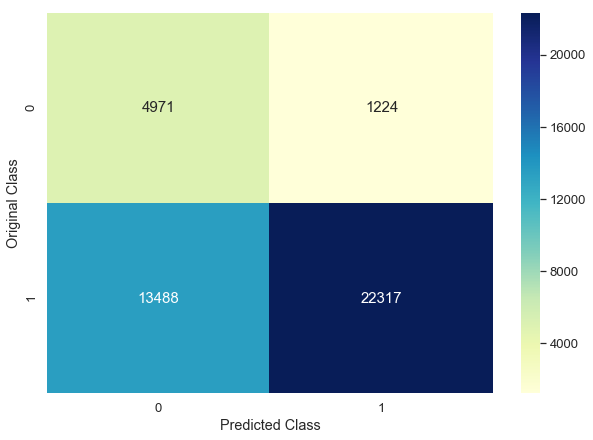

In [179]:
I = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred5,thresholds,train_tpr5,train_fpr5))
plottrainmatrix(I)

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.477858941983983
Threshold for Maximum Value of tpr*(1-fpr) : 0.83


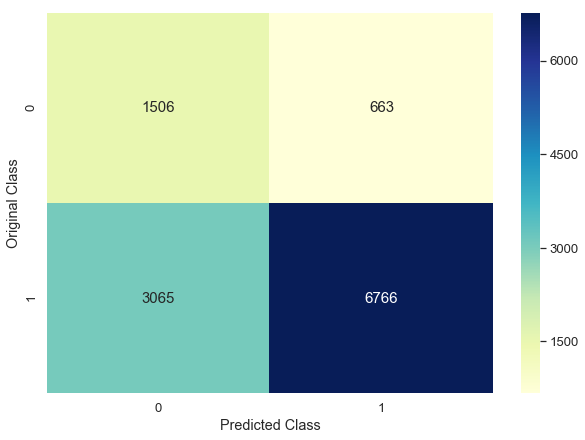

In [180]:
J = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred5,thresholds,test_tpr5,test_fpr5))
plottestmatrix(J)

Overall Accuracy on Test Dataset => (6766+1506)/12000 => 68.93 %

# [5.2.2] Applying KNN KD-Tree on TFIDF

# SET 6 : Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.

In [159]:
tf_idf_vect_KD = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
#While the vocabulary is being built on the Training data using TFIDF, all the words with a frequency lower than the
#value =10 are ignored. Also, both unigram and bi-grams are considered. Also, only the top 500 features over here
#are taken into consideration.

tf_idf_vect_KD.fit(X_Train)
#Again, 'fitting' has been carried out only on the Training data. 

#fit function over here basically internally stores the parameters that will be used for Transforming the data from
#text to a numerical vector :- Using TFIDF in this case. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [160]:
X_Train_KD_TFIDF = tf_idf_vect_KD.transform(X_Train)
X_CV_KD_TFIDF = tf_idf_vect_KD.transform(X_CV)
X_Test_KD_TFIDF = tf_idf_vect_KD.transform(X_Test)

#Again, all the text has been transformed to the Numerical vector that we needed.

In [161]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_Train.shape,Y_Train.shape)
print(X_CV.shape,Y_CV.shape)
print(X_Test.shape,Y_CV.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_Train_KD_TFIDF.shape,Y_Train.shape)
print(X_CV_KD_TFIDF.shape,Y_CV.shape)
print(X_Test_KD_TFIDF.shape,Y_Test.shape)

Shapes before the TFIDF Vectorization was carried out:
(42000,) (42000,)
(6000,) (6000,)
(12000,) (6000,)
Shapes after the TFIDF Vectorization was carried out:
(42000, 500) (42000,)
(6000, 500) (6000,)
(12000, 500) (12000,)


In [162]:
type(X_Train_KD_TFIDF)
type(X_CV_KD_TFIDF)
type(X_Test_KD_TFIDF)

scipy.sparse.csr.csr_matrix

In [163]:
X_Train_KD_TFIDF= X_Train_KD_TFIDF.toarray()
X_CV_KD_TFIDF = X_CV_KD_TFIDF.toarray()
X_Test_KD_TFIDF = X_Test_KD_TFIDF.toarray()

In [164]:
type(X_Train_KD_TFIDF)
type(X_CV_KD_TFIDF)
type(X_Test_KD_TFIDF)

numpy.ndarray

# Hyperparameter Tuning on the TFIDF Representation using KD-Tree :- 

In [167]:
Train_KD_TFIDF_AUC = []
CV_KD_TFIDF_AUC =[]

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(X_Train_KD_TFIDF,Y_Train)
    
    Y_Train_pred6 = neigh.predict_proba(X_Train_KD_TFIDF)[:,1]
    Y_CV_pred6 = neigh.predict_proba(X_CV_KD_TFIDF)[:,1]
    
    Train_KD_TFIDF_AUC.append(roc_auc_score(Y_Train,Y_Train_pred6))
    CV_KD_TFIDF_AUC.append(roc_auc_score(Y_CV,Y_CV_pred6))

100%|██████████| 30/30 [5:59:46<00:00, 737.32s/it]  


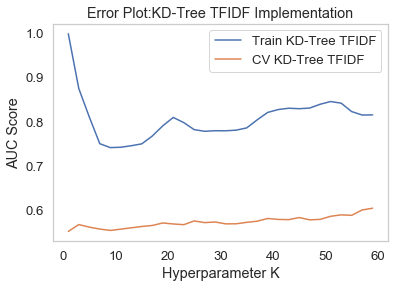

In [182]:
#Plotting the AUC Scores for Train and CV Datasets 

import matplotlib.pyplot as plt

plt.plot(k_param,Train_KD_TFIDF_AUC, label='Train KD-Tree TFIDF')
plt.plot(k_param,CV_KD_TFIDF_AUC, label='CV KD-Tree TFIDF')
plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Score')
plt.title('Error Plot:KD-Tree TFIDF Implementation')

plt.grid(False)
plt.show()

Based on the criteria in choosing the best value of K, we can see:

In [183]:
best_k=15

# Testing on the Test Dataset for the TFIDF Representation using KD-Tree:-

In [184]:
neigh6 = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh6.fit(X_Train_KD_TFIDF,Y_Train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [185]:
X_Train_KD_TFIDF.shape

(42000, 500)

In [186]:
Y_Train.shape

(42000,)

In [187]:
X_Test_KD_TFIDF.shape

(12000, 500)

In [188]:
Y_Test.shape

(12000,)

In [189]:
from sklearn.metrics import roc_auc_score

train_fpr6,train_tpr6,thresholds = roc_curve(Y_Train,neigh6.predict_proba(X_Train_KD_TFIDF)[:,1])
test_fpr6,test_tpr6,thresholds = roc_curve(Y_Test,neigh6.predict_proba(X_Test_KD_TFIDF)[:,1])

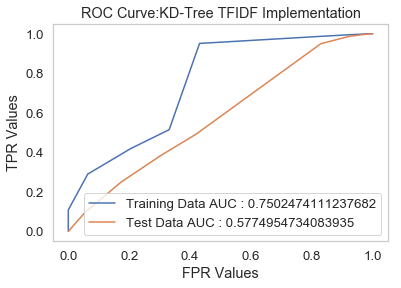

In [191]:
#Plotting the ROC Curves for the Training and Test Datasets:-

import matplotlib.pyplot as plt

plt.plot(train_fpr6,train_tpr6, label='Training Data AUC : ' + str(auc(train_fpr6,train_tpr6)))
plt.plot(test_fpr6,test_tpr6, label='Test Data AUC : ' + str(auc(test_fpr6,test_tpr6)))

plt.legend()
plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve:KD-Tree TFIDF Implementation')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the TFIDF Train Data & Test Data (KD-Tree Implementation) for the Ideal Value of the Threshold:- </font> </b>

In [192]:
#To plot the confusion matrix
Y_Test_pred6 = neigh6.predict_proba(X_Test_KD_TFIDF)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.540841836875579
Threshold for Maximum Value of tpr*(1-fpr) : 0.733


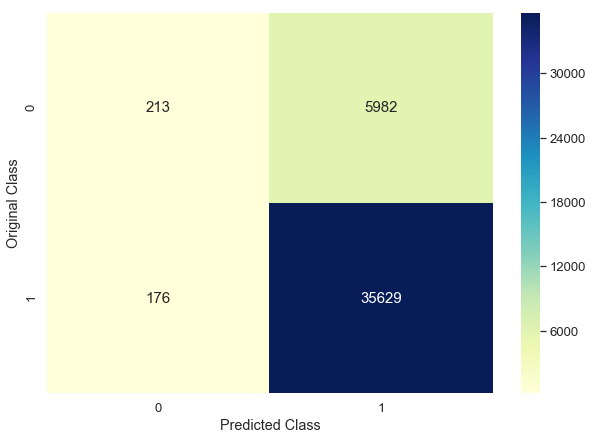

In [193]:
K = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred6,thresholds,train_tpr6,train_fpr6))
plottrainmatrix(K)

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.28534515469104205
Threshold for Maximum Value of tpr*(1-fpr) : 0.8


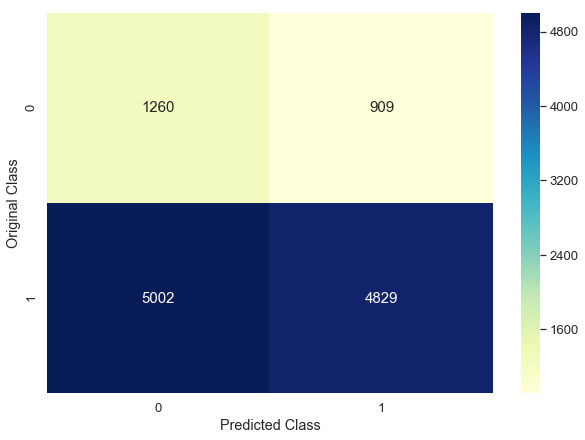

In [194]:
L = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred6,thresholds,test_tpr6,test_fpr6))
plottestmatrix(L)

Overall Accuracy on the Test Dataset = (4829+1260)/12000 => 50.74 % 

# [5.2.3] Applying KNN KD-tree on Avg W2V

# SET 7: Review text, preprocessed one converted into vectors using (AVG W2V)

The Review Text has already been converted into vectors above using the Avg W2V Approach and the vectors thus obtained for the Training, CV and the Test Datasets are sent_vectors_train, sent_vectors_cv and sent_vectors_test. The dimensionality of these vectors is as shown below:

In [195]:
#Following are the shapes after the Avg W2V Implementation is carried out:-

print(sent_vectors_train.shape,Y_Train.shape)
print(sent_vectors_cv.shape,Y_CV.shape)
print(sent_vectors_test.shape,Y_Test.shape)

(42000, 50) (42000,)
(6000, 50) (6000,)
(12000, 50) (12000,)


Before we carry out KD-Tree implementation on the Avg W2V vectorization it needs to be converted into a dense
matrix. However in this scenario we already have what we require and no further processing needs to be carried out 
in this particular scenario.

In [197]:
type(sent_vectors_train)
type(sent_vectors_cv)
type(sent_vectors_test)

numpy.ndarray

# Hyperparameter Tuning on the Avg W2V Representation using KD-Tree :- 

In [198]:
print(k_param)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]


In [199]:
from sklearn.metrics import roc_auc_score

Train_KD_AW2V_AUC=[]
CV_KD_AW2V_AUC=[]

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(sent_vectors_train,Y_Train)
    
    Y_Train_pred7 = neigh.predict_proba(sent_vectors_train)[:,1]
    Y_CV_pred7 = neigh.predict_proba(sent_vectors_cv)[:,1]
    
    Train_KD_AW2V_AUC.append(roc_auc_score(Y_Train,Y_Train_pred7))
    CV_KD_AW2V_AUC.append(roc_auc_score(Y_CV,Y_CV_pred7))

100%|██████████| 30/30 [1:22:13<00:00, 133.53s/it]


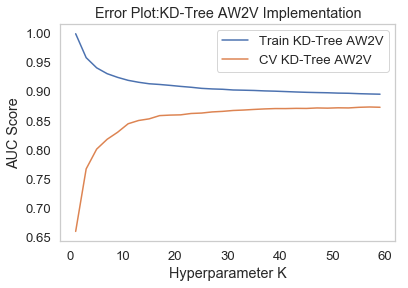

In [201]:
#Plotting the AUC Scores for the different values of the Hyperparameter K:-

import matplotlib.pyplot as plt

plt.plot(k_param,Train_KD_AW2V_AUC, label='Train KD-Tree AW2V')
plt.plot(k_param,CV_KD_AW2V_AUC, label='CV KD-Tree AW2V')
plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Score')
plt.title('Error Plot:KD-Tree AW2V Implementation')

plt.grid(False)
plt.show()

In [202]:
#According to the criteria on the basis of which we choose the Best Value of K
best_k=59

# Testing on the Test Dataset for the AW2V Representation using KD-Tree:-

In [203]:
neigh7 = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh7.fit(sent_vectors_train,Y_Train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=59, p=2,
           weights='uniform')

In [204]:
sent_vectors_train.shape

(42000, 50)

In [205]:
Y_Train.shape

(42000,)

In [206]:
sent_vectors_cv.shape

(6000, 50)

In [207]:
Y_CV.shape

(6000,)

In [208]:
from sklearn.metrics import roc_auc_score

train_fpr7,train_tpr7,thresholds = roc_curve(Y_Train,neigh7.predict_proba(sent_vectors_train)[:,1])
test_fpr7,test_tpr7,thresholds = roc_curve(Y_Test,neigh7.predict_proba(sent_vectors_test)[:,1])

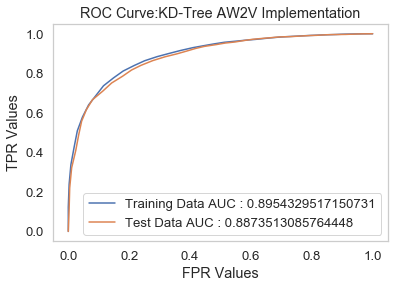

In [210]:
#Plotting the ROC Curves for the Training and Test Datasets:-

import matplotlib.pyplot as plt

plt.plot(train_fpr7,train_tpr7, label='Training Data AUC : ' + str(auc(train_fpr7,train_tpr7)))
plt.plot(test_fpr7,test_tpr7, label='Test Data AUC : ' + str(auc(test_fpr7,test_tpr7)))

plt.legend()
plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve:KD-Tree AW2V Implementation')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the Avg W2V Train Data & Test Data for the Ideal Value
of the Threshold:- </font> </b>

In [211]:
#To plot the confusion matrix
Y_Test_pred7 = neigh7.predict_proba(sent_vectors_test)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6651115793004413
Threshold for Maximum Value of tpr*(1-fpr) : 0.831


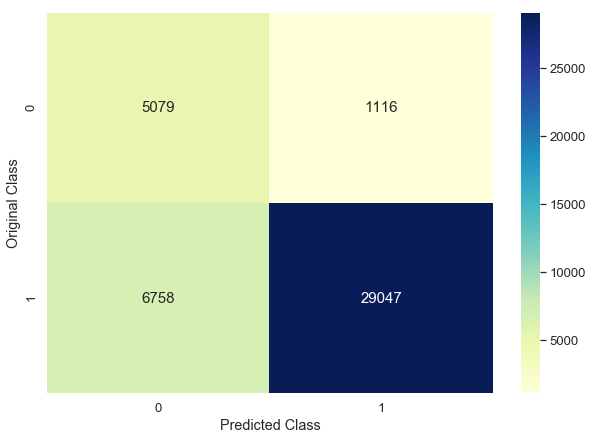

In [212]:
M = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred7,thresholds,train_tpr7,train_fpr7))
plottrainmatrix(M)

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6468048610733006
Threshold for Maximum Value of tpr*(1-fpr) : 0.814


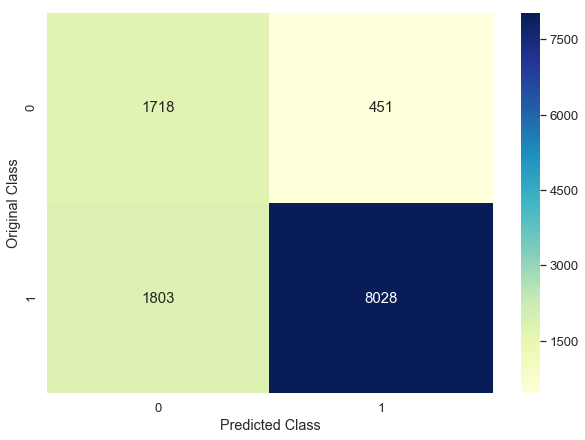

In [213]:
N = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred7,thresholds,test_tpr7,test_fpr7))
plottestmatrix(N)

Overall Accuracy on the Test Dataset = (8028+1718)/12000 => 81.21 % 

# [5.2.4] Applying KNN KD-Tree on TFIDF W2V

# SET 8: Review text, preprocessed one converted into vectors using (TFIDF W2V)

The Review Text has already been converted into vectors above using the TFIDF W2V Approach and the vectors thus obtained for the Training, CV and the Test Datasets are tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test. 
The length of these lists is as shown below:

In [214]:
len(tfidf_sent_vectors_train)

42000

In [215]:
len(tfidf_sent_vectors_cv)

6000

In [216]:
len(tfidf_sent_vectors_test)

12000

The tfidf_sent_vectors_train/cv/test is already a list and in order to convert the same into a numpy dense representation, we can use the asarray() function in numpy to convert the list into a dense representation for the
KD-Tree implementation to act on it.

In [217]:
tfidf_sent_vectors_train = np.asarray(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv = np.asarray(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test = np.asarray(tfidf_sent_vectors_test)

In [218]:
type(tfidf_sent_vectors_train)
type(tfidf_sent_vectors_cv)
type(tfidf_sent_vectors_test)

numpy.ndarray

Now we can carry out the rest of the steps on the same.

# Hyperparameter Tuning on the TFIDF W2V Representation using KD-Tree :- 

In [219]:
print(k_param)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]


In [220]:
from sklearn.metrics import roc_auc_score

Train_KD_TFIDFW2V_AUC=[]
CV_KD_TFIDFW2V_AUC=[]

for k in tqdm(k_param):
    neigh = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(tfidf_sent_vectors_train,Y_Train)
    
    Y_Train_pred8 = neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_CV_pred8 = neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    Train_KD_TFIDFW2V_AUC.append(roc_auc_score(Y_Train,Y_Train_pred8))
    CV_KD_TFIDFW2V_AUC.append(roc_auc_score(Y_CV,Y_CV_pred8))   

100%|██████████| 30/30 [52:53<00:00, 115.26s/it]


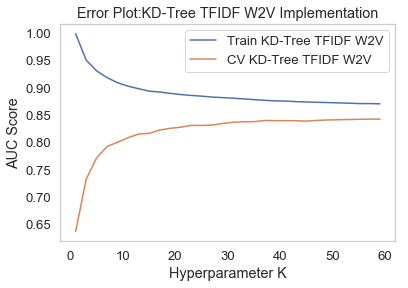

In [222]:
#Plotting the AUC Scores for the different values of the Hyperparameter K:-

import matplotlib.pyplot as plt

plt.plot(k_param,Train_KD_TFIDFW2V_AUC, label='Train KD-Tree TFIDF W2V')
plt.plot(k_param,CV_KD_TFIDFW2V_AUC, label='CV KD-Tree TFIDF W2V')
plt.legend()

plt.xlabel('Hyperparameter K')
plt.ylabel('AUC Score')
plt.title('Error Plot:KD-Tree TFIDF W2V Implementation')

plt.grid(False)
plt.show()

In [223]:
best_k=57

# Testing on the Test Dataset for the TFIDF W2V Representation using KD-Tree:-

In [224]:
neigh8 = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh8.fit(tfidf_sent_vectors_train,Y_Train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=57, p=2,
           weights='uniform')

In [225]:
tfidf_sent_vectors_train.shape

(42000, 50)

In [226]:
Y_Train.shape

(42000,)

In [227]:
tfidf_sent_vectors_test.shape

(12000, 50)

In [228]:
Y_Test.shape

(12000,)

In [229]:
from sklearn.metrics import roc_auc_score

train_fpr8,train_tpr8,thresholds = roc_curve(Y_Train,neigh8.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr8,test_tpr8,thresholds = roc_curve(Y_Test,neigh8.predict_proba(tfidf_sent_vectors_test)[:,1])

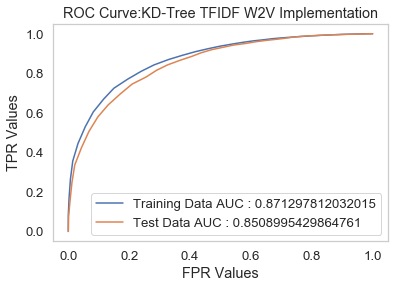

In [231]:
#Plotting the ROC Curves for the Training and Test Datasets:-

import matplotlib.pyplot as plt

plt.plot(train_fpr8,train_tpr8, label='Training Data AUC : ' + str(auc(train_fpr8,train_tpr8)))
plt.plot(test_fpr8,test_tpr8, label='Test Data AUC : ' + str(auc(test_fpr8,test_tpr8)))

plt.legend()
plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve:KD-Tree TFIDF W2V Implementation')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the TFIDF W2V Train Data & Test Data (using KD-Tree implementation) for the Ideal Value of the Threshold:- </font> </b>

In [232]:
#To plot the confusion matrix
Y_Test_pred8 = neigh8.predict_proba(tfidf_sent_vectors_test)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6199554555158711
Threshold for Maximum Value of tpr*(1-fpr) : 0.842


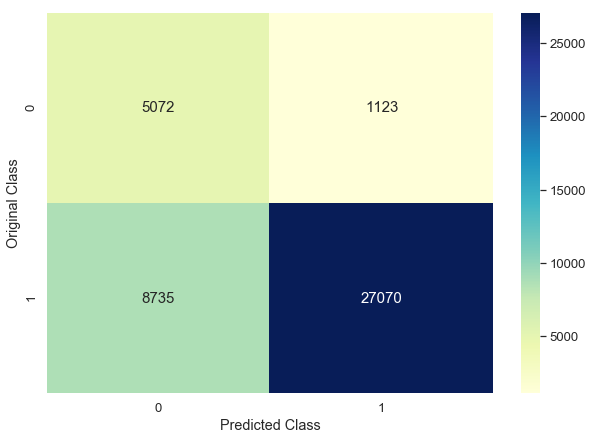

In [233]:
O = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred8,thresholds,train_tpr8,train_fpr8))
plottrainmatrix(O)

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5890321912895945
Threshold for Maximum Value of tpr*(1-fpr) : 0.842


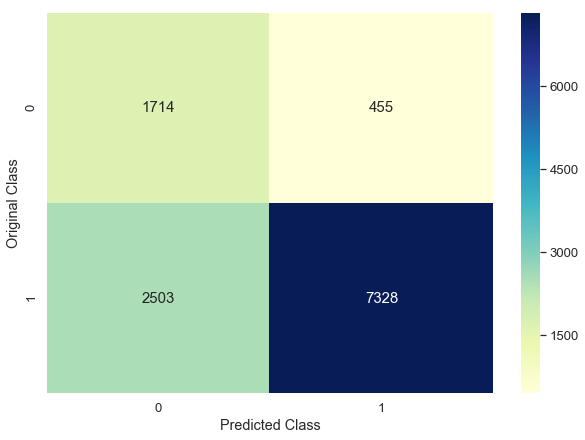

In [234]:
P = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred8,thresholds,test_tpr8,test_fpr8))
plottestmatrix(P)

Overall Accuracy on the Test Dataset = (7328+1714)/12000 => 75.35 % 

# [6] Conclusions

Summarizing the results that I obtained in the PrettyTable format will be as follows:

In [239]:
from prettytable import PrettyTable

In [240]:
x=PrettyTable()
x.field_names=["S No.","Model","Best Value of K","Test Accuracy on Ideal Threshold","Test AUC Score"]

In [241]:
x.add_row(["1","BOW : Brute Force","59","61.85%","0.693"])
x.add_row(["2","TFIDF : Brute Force","59","44.70%","0.497"])
x.add_row(["3","Avg W2V : Brute Force","59","81.21%","0.887"])
x.add_row(["4","TFIDF W2V : Brute Force","59","76.75%","0.851"])
x.add_row(["5","BOW : KD-Tree","53","68.93%","0.762"])
x.add_row(["6","TFIDF : KD-Tree","15","50.74%","0.577"])
x.add_row(["7","Avg W2V : KD-Tree","59","81.21%","0.887"])
x.add_row(["8","TFIDF W2V :KD-Tree","57","75.35%","0.850"])

print(x)

+-------+-------------------------+-----------------+----------------------------------+----------------+
| S No. |          Model          | Best Value of K | Test Accuracy on Ideal Threshold | Test AUC Score |
+-------+-------------------------+-----------------+----------------------------------+----------------+
|   1   |    BOW : Brute Force    |        59       |              61.85%              |     0.693      |
|   2   |   TFIDF : Brute Force   |        59       |              44.70%              |     0.497      |
|   3   |  Avg W2V : Brute Force  |        59       |              81.21%              |     0.887      |
|   4   | TFIDF W2V : Brute Force |        59       |              76.75%              |     0.851      |
|   5   |      BOW : KD-Tree      |        53       |              68.93%              |     0.762      |
|   6   |     TFIDF : KD-Tree     |        15       |              50.74%              |     0.577      |
|   7   |    Avg W2V : KD-Tree    |        59 

Some of the Conclusions on the same are as follows:
   * The greater is the AUC Score, better is the model. Accuracy as a metric is measured on the Test Data with the
      help of the confusion matrix that we generated on the Test dataset.
   * Simple TFIDF Implementations for both Brute Force as well as the KD-Tree Implementations of K-NN are the worst
     as compared to the remaining implementations because of the low AUC Score Values, which is only marginally            better than 0.5:- AUC Score of a random dumb model.
       

 * In order to fix this low AUC Score for the TFIDF- Brute Force and KD-Tree Implementations I tried the following
      approaches:
 * Using only the top 2000 Features:- In such a scenario I was able to marginally improve the value of Test              AUC to 0.52.
 * Using weights ='distance' as a parameter for the KNN Model to try and curb the imbalanced dataset. In such
   a scenario the Training AUC became very high ie. 0.99 whereas the Testing AUC remained the same : equal to
   0.49 which meant that I was overfitting on the Training dataset.

* Avg W2V, in both the Brute Force as well as the KD-Tree Implementations return the Highest AUC Scores.
* "TFIDF:Brute Force" is the worst performing model on the Test data with a very low value of AUC Score.